In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import pandas as pd
from glob import glob

In [2]:
# import zipfile

# #** unzip the folder GLEM_daily_dataset.zip **
# with zipfile.ZipFile("GLEM_daily_dataset.zip", "r") as zip_ref:
#     zip_ref.extractall("GLEM_daily_dataset")

# #** unzip the folder MADIA_daily_dataset_v1.3.zip **
# with zipfile.ZipFile("MADIA_daily_dataset_v1.3.zip", "r") as zip_ref:
#     zip_ref.extractall("MADIA_daily_dataset_v1.3")

In [3]:
#** load the dataframe of climatological variables **

# load data from the csv files
csv_files = sorted(glob("./MADIA_daily_dataset_v1.3/csv_data/*_e5_d.csv"))
csv_files = [file for file in csv_files if 2019 <= int(file.split('/')[-1].split('_')[0]) <= 2023]

dailyClimatological_data = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)

    # keep only the data that are referred to the Piedmont region
    df_piedmont = df[df['latitude'].between(44.0, 46.5) & df['longitude'].between(6.5, 9.0)]
    
    global_dailyClimatological_data = pd.concat([dailyClimatological_data, df], ignore_index=True)
    dailyClimatological_data = pd.concat([dailyClimatological_data, df_piedmont], ignore_index=True)

print(dailyClimatological_data.head())

# tasmin    mean of daily minimum near-surface air temperature
# tasmean   mean of daily average near-surface air temperature
# tasmax    mean of daily maximum near-surface air temperature
# rhmin     mean of daily minimum near-surface relative air humidity
# rhmax     mean of daily maximum near-surface relative air humidity
# ws10      mean of daily wind speed
# ssrd      mean of daily surface solar radiation downwards (shortwave radiation)
# ppn       sum of daily depth of water-equivalent precipitation
# pev       sum of daily crop reference evapotranspiration estimated by FAO Penman-Monteith method
# zg        geopotential height: average cell height (metres) above the geoid, which corresponds approximately to the elevation
# dekad     number of dekad from the beginning of the year
# expver    code which identiﬁes temporary data when expver=5
# mask      boolean code to identify cells belonging to the Italian country

   longitude  latitude        time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0  2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0  2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0  2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0  2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0  2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0  
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0  
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0  
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0  
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0  


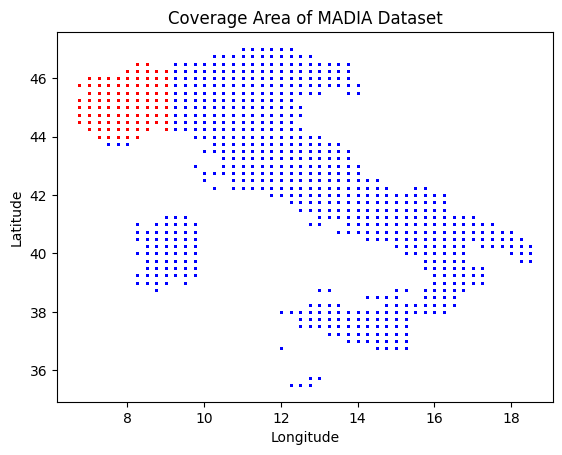

In [4]:
# **show a plot of the coverage area of the MADIA dataset**
# color in red the area of the Piedmont region

plt.scatter(global_dailyClimatological_data['longitude'], global_dailyClimatological_data['latitude'], s=1, c='blue', alpha=0.5)
plt.scatter(dailyClimatological_data['longitude'], dailyClimatological_data['latitude'], s=1, c='red', alpha=0.5)
plt.title('Coverage Area of MADIA Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
#** load the dataset of Evapotranspiration from the nc file
nc_files = sorted(glob("./GLEM_daily_dataset/E_*_GLEAM_v4.2a.nc"))

dailyE_data = []

for file in nc_files:
    ds = xr.open_dataset(file)

    # the evapotranspiration data are referenced to the Global territory
    E_lon = ds['lon'].values
    E_lat = ds['lat'].values

    # the climatological data are referenced to the Italian territory
    clim_lon = dailyClimatological_data['longitude'].values
    clim_lat = dailyClimatological_data['latitude'].values

    # select the evapotranspiration data for the Italian territory
    E_lon_idx = np.where((E_lon >= clim_lon.min()) & (E_lon <= clim_lon.max()))
    E_lat_idx = np.where((E_lat >= clim_lat.min()) & (E_lat <= clim_lat.max()))
    E_lon = E_lon[E_lon_idx]
    E_lat = E_lat[E_lat_idx]

    E_data = ds['E'].sel(lon=E_lon, lat=E_lat)
    dailyE_data.append(E_data)

dailyE_data = xr.concat(dailyE_data, dim='time')

/tmp/ipykernel_18815/3907745109.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap


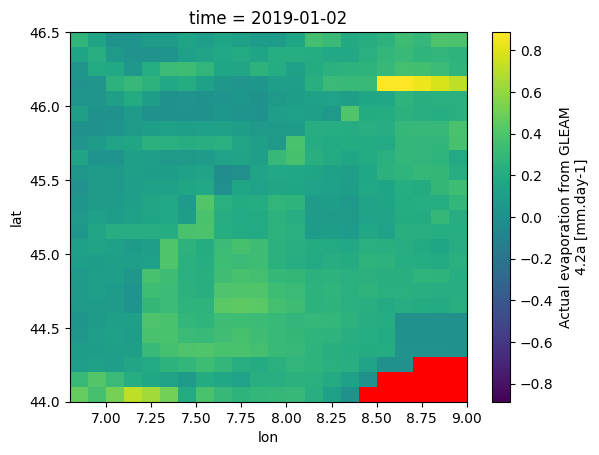

Daily Evapotranspiration shape (time, latitude, longitude): (1826, 25, 22)
Number of NaN values in the dataset: 14


In [6]:
#** show a plot of the Evapotranspiration data **
et = dailyE_data.isel(time=1)

cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap
cmap.set_bad(color='red')  # highlight NaN values in red

et.plot(cmap=cmap)  # plot the data with the modified colormap

plt.show()

print(f"Daily Evapotranspiration shape (time, latitude, longitude): {dailyE_data.shape}")

# count the number of pixel that are NaN at any time
nan_pixels = np.isnan(dailyE_data).any(dim='time').sum().item()
print(f"Number of NaN values in the dataset: {nan_pixels}")

In [7]:
#** evaluate the elapsed_days **
dailyClimatological_data['time'] = pd.to_datetime(dailyClimatological_data['time'])
dailyClimatological_data['elapsed_days'] = (dailyClimatological_data['time'] - dailyClimatological_data['time'].min()).dt.days.values
dailyClimatological_data['day_of_year'] = dailyClimatological_data['time'].dt.dayofyear.values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0 2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0 2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0 2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0 2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0   
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0   
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0   
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0   
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0   

   elapsed_days  day_of_year  
0             0            1  
1             1            2  
2             2            3 

In [8]:
#** associate the Evapotranspiration data to the climatological data **

# build a 2D grid of lat/lon points with the evapotranspiration data
grid_lat = dailyE_data['lat'].values
grid_lon = dailyE_data['lon'].values
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

from scipy.spatial import cKDTree

# build a KDTree for fast nearest-neighbor search
grid_points = np.column_stack([grid_lat2d.ravel(), grid_lon2d.ravel()])
tree = cKDTree(grid_points)

# extract (lat, lon) from the climate data
query_points = dailyClimatological_data[['latitude', 'longitude']].values

# query the nearest grid points once
distances, indices = tree.query(query_points)

# convert flat indices to 2D (lat_idx, lon_idx)
lat_idx, lon_idx = np.unravel_index(indices, grid_lat2d.shape)

# time indices, evaluate the amount of days elapsed since the first day of the dataset
time_idx = dailyClimatological_data['elapsed_days']

# get values from xarray using vectorized indexing
E_values = dailyE_data.isel(
    time=xr.DataArray(time_idx, dims='points'),
    lat=xr.DataArray(lat_idx, dims='points'),
    lon=xr.DataArray(lon_idx, dims='points')
).values

# Assign to DataFrame
dailyClimatological_data['E'] = E_values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

print(f"Correction (degrees) - mean: {np.mean(distances):.6f}, min: {np.min(distances):.6f}, max: {np.max(distances):.6f}")

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0 2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0 2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0 2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0 2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0   
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0   
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0   
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0   
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0            1  0.182108  
1             1            2  0.642770  

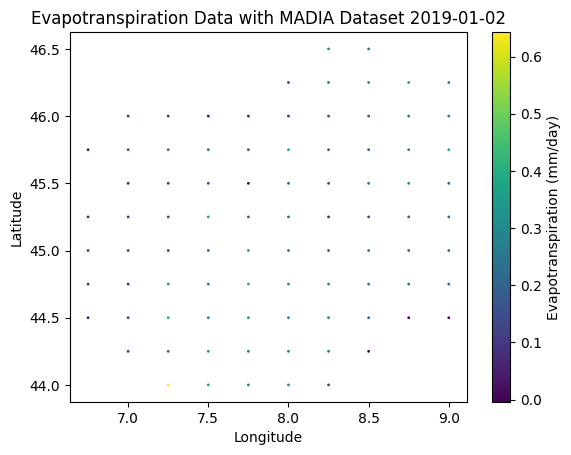

In [9]:
#** show a plot of the Evapotranspiration data with the MADIA dataset **
et = dailyClimatological_data[dailyClimatological_data['elapsed_days'] == 1]
plt.scatter(et['longitude'], et['latitude'], s=1, c=et['E'], cmap='viridis')
plt.colorbar(label='Evapotranspiration (mm/day)')
plt.title(f'Evapotranspiration Data with MADIA Dataset {et["time"].dt.strftime("%Y-%m-%d").values[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
#** drop the rows with NaN values in the Evapotranspiration column **
print(f"Number of rows before dropping NaN values: {len(dailyClimatological_data)}")
dailyClimatological_data = dailyClimatological_data.dropna(subset=['E'])
print(f"Number of rows after dropping NaN values: {len(dailyClimatological_data)}")

Number of rows before dropping NaN values: 128568
Number of rows after dropping NaN values: 127107


In [11]:
#** print the fields of the dataframe **
print(dailyClimatological_data.columns)

Index(['longitude', 'latitude', 'time', 'tasmin', 'tasmax', 'tasmean', 'rhmin',
       'rhmax', 'ws10', 'ssrd', 'ppn', 'pev', 'expver', 'mask', 'elapsed_days',
       'day_of_year', 'E'],
      dtype='object')


In [12]:
#** apply normalization to the features **
from sklearn.preprocessing import MinMaxScaler

# normilize the features
features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
featureScaler = MinMaxScaler()
dailyClimatological_data[features] = featureScaler.fit_transform(dailyClimatological_data[features])

# normilize the target
target = 'E'
targetScaler = MinMaxScaler()
dailyClimatological_data[target] = targetScaler.fit_transform(dailyClimatological_data[[target]])

print(dailyClimatological_data.head())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01  0.480521  0.438215  0.449180  0.553127   
1       7.25      44.0 2019-01-02  0.511694  0.471987  0.482378  0.289283   
2       7.25      44.0 2019-01-03  0.468833  0.395152  0.420706  0.637439   
3       7.25      44.0 2019-01-04  0.449429  0.364368  0.394895  0.562217   
4       7.25      44.0 2019-01-05  0.454615  0.429194  0.431630  0.348014   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.806139  0.060332  0.150205  0.000034  0.449662     1.0   1.0   
1  0.771313  0.080010  0.165024  0.028310  0.686820     1.0   1.0   
2  0.868496  0.068606  0.171279  0.017009  0.366639     1.0   1.0   
3  0.845123  0.066608  0.131335  0.010217  0.424469     1.0   1.0   
4  0.571988  0.099463  0.222733  0.000045  0.647863     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0     0.000000  0.041058  
1             1     0.002740  0.122753  

In [13]:
# ** build the dataset for a ML model **

# dynamic time wrapping (DTW)
# X = dailyClimatological_data[features]
# y = dailyClimatological_data[target]

**LSTM:**
- sequence lenght = 30
- features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
- loss = Huber loss

In [14]:
#** select random samples from the dataset **
 
# select half of the unique points in the dataset
n_samples = int(len(np.unique(dailyClimatological_data[['longitude', 'latitude']])) / 2)
unique_locations = dailyClimatological_data[['longitude', 'latitude']].drop_duplicates()

# sample n_samples unique locations
sampled_locations = unique_locations.sample(n=n_samples, random_state=42)

X_sequences = []
y_sequences = []

sequence_length = 30

for _, loc in sampled_locations.iterrows():
    loc_data = dailyClimatological_data[
        (dailyClimatological_data['longitude'] == loc['longitude']) &
        (dailyClimatological_data['latitude'] == loc['latitude'])
    ].sort_values(by='elapsed_days')

    features = loc_data[['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']].values
    target = loc_data['E'].values
        
    for i in range(len(loc_data) - sequence_length):
        X_seq = features[i:i+sequence_length]
        y_val = target[i+sequence_length]
        X_sequences.append(X_seq)
        y_sequences.append(y_val)

X = np.array(X_sequences)
y = np.array(y_sequences)

In [15]:
#** build a dataset of shape (n_samples, n_features) **
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape: (14310, 30, 9)
Target vector shape: (14310,)
[[0.00000000e+00 4.39902354e-01 4.05382116e-01 3.93186352e-01
  3.44009005e-01 6.23168365e-01 1.51962696e-01 1.70812989e-01
  0.00000000e+00]
 [2.73972603e-03 4.52824393e-01 3.92710348e-01 3.57043669e-01
  4.00312007e-01 4.81236781e-01 1.71164417e-01 1.59783654e-01
  5.95046052e-04]
 [5.47945205e-03 4.02267584e-01 3.55467378e-01 3.33757984e-01
  3.36294769e-01 4.04081466e-01 1.63102270e-01 1.97750559e-01
  0.00000000e+00]
 [8.21917808e-03 3.66073438e-01 3.27329473e-01 3.14289029e-01
  3.84726369e-01 5.40640804e-01 1.48519021e-01 1.88304435e-01
  0.00000000e+00]
 [1.09589041e-02 3.86361735e-01 3.62488991e-01 3.61977977e-01
  4.40571862e-01 4.68841223e-01 2.04413295e-01 1.76825280e-01
  5.07170703e-04]]
0.07030196


In [16]:
#** mix the sequences of data **
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

print(f"Feature matrix shape after shuffle: {X.shape}")
print(f"Target vector shape after shuffle: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape after shuffle: (14310, 30, 9)
Target vector shape after shuffle: (14310,)
[[2.10958904e-01 6.06101270e-01 5.94788676e-01 5.96781777e-01
  3.55341766e-01 7.37097196e-01 6.53710818e-02 5.46195747e-01
  0.00000000e+00]
 [2.13698630e-01 6.23667040e-01 6.14169297e-01 6.17089808e-01
  3.54769254e-01 7.53113102e-01 9.42153621e-02 5.71202882e-01
  0.00000000e+00]
 [2.16438356e-01 6.31565684e-01 5.92710071e-01 5.68983865e-01
  4.72461499e-01 8.15773809e-01 1.12304954e-01 4.21831427e-01
  3.17036860e-03]
 [2.19178082e-01 6.05101938e-01 5.89616146e-01 5.87906049e-01
  5.04062372e-01 8.54984876e-01 8.90428977e-02 5.69959634e-01
  3.62738520e-04]
 [2.21917808e-01 6.60816315e-01 5.68555615e-01 4.95762838e-01
  6.53011884e-01 9.32630151e-01 9.37926702e-02 1.74797178e-01
  5.34007885e-02]]
0.4022204


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (11448, 30, 9), (11448,)
Testing set shape: (2862, 30, 9), (2862,)


In [18]:
import tensorflow as tf
from tensorflow.keras.losses import Huber

print(tf.config.list_physical_devices('GPU'))

# the model learns to predict the next day ET value based on the previous 30 days of data

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(sequence_length, 9)))  # input shape (sequence_length, n_features)
model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # return_sequences=True, each of the LSTM cells returns its sequence of 128 outputs. So the output shape is (batch_size, sequence_length, 128)

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # return_sequences=False, the last LSTM cell returns its last output. So the output shape is (batch_size, 64)
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1))  # predict a single ET value

# huber loss function
huber_loss = Huber(delta=1.0)
# compile the model
# model.compile(optimizer='adam', loss=huber_loss)
model.compile(optimizer='adam', loss=huber_loss)
model.summary()

2025-05-19 17:00:33.871836: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 17:00:33.895119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747666833.919670   18815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747666833.926986   18815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747666833.944700   18815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1747666836.753600   18815 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1722 MB memory:  -> device: 0, name: NVIDIA GeForce MX350, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,289 (485.50 KB)

 Trainable params: 124,289 (485.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# i am feeding the NN with 32 sequences at a time (batch size). Each of these sequences is made by 30 days of data, each data is made by 8 features
# I have 7010 * 0.8 due to train and test set split, these sequences are divided in batches of 32 and with a validation split of 0.2, means that the number of iterations needed to complete each epoch is 7010 * 0.8 * 0.8 / 32 = 140.2
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


I0000 00:00:1747666842.077315   18926 cuda_dnn.cc:529] Loaded cuDNN version 90501


287/287 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/ste

In [20]:
#** test the model on the test set **
y_pred = model.predict(X_test)

# invert the normalization of the predicted values
y_pred_rescaled = targetScaler.inverse_transform(y_pred)
y_test_rescaled = targetScaler.inverse_transform(y_test.reshape(-1, 1))

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"R2 score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

R2 score: 0.8993
MAPE: 0.5511


In [34]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true) / (denominator + 1e-8)
    return 100 * np.mean(diff)

smape = symmetric_mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"SMAPE: {smape:.4f}")

SMAPE: 24.1836


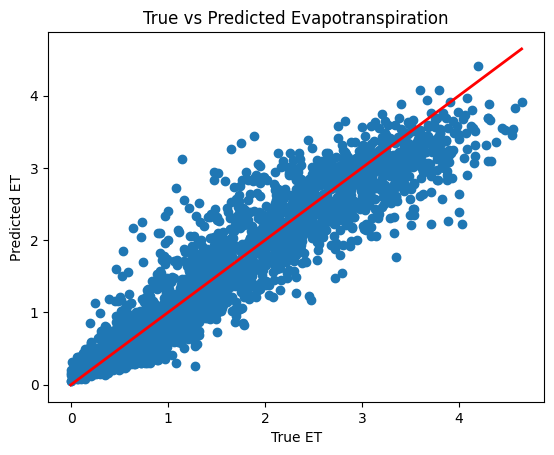

In [22]:
#**  see a plot of the accuracy of the predictions **
plt.scatter(y_test_rescaled, y_pred_rescaled)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()

**LSTM:**
- sequence lenght = 14
- features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
- loss = MSE

In [23]:
#** select random samples from the dataset **
 
# select half of the unique points in the dataset
n_samples = int(len(np.unique(dailyClimatological_data[['longitude', 'latitude']])) / 2)
unique_locations = dailyClimatological_data[['longitude', 'latitude']].drop_duplicates()

# sample n_samples unique locations
sampled_locations = unique_locations.sample(n=n_samples, random_state=42)

X_sequences = []
y_sequences = []

sequence_length = 14

for _, loc in sampled_locations.iterrows():
    loc_data = dailyClimatological_data[
        (dailyClimatological_data['longitude'] == loc['longitude']) &
        (dailyClimatological_data['latitude'] == loc['latitude'])
    ].sort_values(by='elapsed_days')

    features = loc_data[['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']].values
    target = loc_data['E'].values
        
    for i in range(len(loc_data) - sequence_length):
        X_seq = features[i:i+sequence_length]
        y_val = target[i+sequence_length]
        X_sequences.append(X_seq)
        y_sequences.append(y_val)

X = np.array(X_sequences)
y = np.array(y_sequences)

In [24]:
#** build a dataset of shape (n_samples, n_features) **
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape: (14470, 14, 9)
Target vector shape: (14470,)
[[0.00000000e+00 4.39902354e-01 4.05382116e-01 3.93186352e-01
  3.44009005e-01 6.23168365e-01 1.51962696e-01 1.70812989e-01
  0.00000000e+00]
 [2.73972603e-03 4.52824393e-01 3.92710348e-01 3.57043669e-01
  4.00312007e-01 4.81236781e-01 1.71164417e-01 1.59783654e-01
  5.95046052e-04]
 [5.47945205e-03 4.02267584e-01 3.55467378e-01 3.33757984e-01
  3.36294769e-01 4.04081466e-01 1.63102270e-01 1.97750559e-01
  0.00000000e+00]
 [8.21917808e-03 3.66073438e-01 3.27329473e-01 3.14289029e-01
  3.84726369e-01 5.40640804e-01 1.48519021e-01 1.88304435e-01
  0.00000000e+00]
 [1.09589041e-02 3.86361735e-01 3.62488991e-01 3.61977977e-01
  4.40571862e-01 4.68841223e-01 2.04413295e-01 1.76825280e-01
  5.07170703e-04]]
0.04691619


In [25]:
#** mix the sequences of data **
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

print(f"Feature matrix shape after shuffle: {X.shape}")
print(f"Target vector shape after shuffle: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape after shuffle: (14470, 14, 9)
Target vector shape after shuffle: (14470,)
[[6.02739726e-02 4.34442578e-01 4.06420609e-01 4.00270994e-01
  3.39456132e-01 6.08478709e-01 6.59253635e-02 2.43005565e-01
  0.00000000e+00]
 [6.30136986e-02 3.99368867e-01 3.79997632e-01 3.83005510e-01
  4.73839973e-01 6.86380399e-01 6.82532934e-02 2.12142714e-01
  2.22496906e-03]
 [6.57534247e-02 4.28484771e-01 3.89128018e-01 3.73049510e-01
  5.52180113e-01 8.46279692e-01 7.09232481e-02 2.21804566e-01
  8.36861961e-04]
 [6.84931507e-02 4.30406520e-01 3.90570594e-01 3.73985679e-01
  5.18229742e-01 7.74495487e-01 9.10200268e-02 2.35808915e-01
  9.39690867e-04]
 [7.12328767e-02 4.35095523e-01 3.96730164e-01 3.81277276e-01
  4.18149762e-01 9.99754227e-01 9.45180081e-02 2.10544244e-01
  3.52482630e-02]]
0.09709738


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (11576, 14, 9), (11576,)
Testing set shape: (2894, 14, 9), (2894,)


In [27]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

# the model learns to predict the next day ET value based on the previous 30 days of data

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(sequence_length, 9)))  # input shape (sequence_length, n_features)
model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # return_sequences=True, each of the LSTM cells returns its sequence of 128 outputs. So the output shape is (batch_size, sequence_length, 128)

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # return_sequences=False, the last LSTM cell returns its last output. So the output shape is (batch_size, 64)
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1))  # predict a single ET value

model.compile(optimizer='adam', loss='mse')
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 14, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,289 (485.50 KB)

 Trainable params: 124,289 (485.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# i am feeding the NN with 32 sequences at a time (batch size). Each of these sequences is made by 30 days of data, each data is made by 8 features
# I have 7010 * 0.8 due to train and test set split, these sequences are divided in batches of 32 and with a validation split of 0.2, means that the number of iterations needed to complete each epoch is 7010 * 0.8 * 0.8 / 32 = 140.2
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0201 - val_loss: 0.0070
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 12/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
#** test the model on the test set **
y_pred = model.predict(X_test)

# invert the normalization of the predicted values
y_pred_rescaled = targetScaler.inverse_transform(y_pred)
y_test_rescaled = targetScaler.inverse_transform(y_test.reshape(-1, 1))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"R2 score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

R2 score: 0.8993
MAPE: 0.5511


In [ ]:
smape = symmetric_mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"SMAPE: {smape:.4f}")

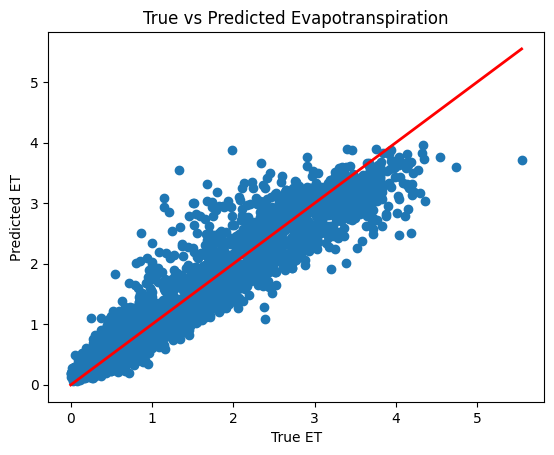

In [31]:
#**  see a plot of the accuracy of the predictions **
plt.scatter(y_test_rescaled, y_pred_rescaled)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()